In [1]:
!git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
%cd DeepGenerativeModels

Cloning into 'DeepGenerativeModels'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 490 (delta 16), reused 27 (delta 7), pack-reused 447
Receiving objects: 100% (490/490), 135.97 MiB | 32.79 MiB/s, done.
Resolving deltas: 100% (196/196), done.
/content/DeepGenerativeModels


# Загрузка данных

В качестве данных будем использовать датасет с лицами CelebA

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from utils.datasets.celeba import CelebADataset

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.utils as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional
import PIL
import os

batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transforms = transforms.Compose([ # Compose combines a number of transforms into one operation
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # PIL Image -> Tensor
    transforms.Normalize([0.5], [0.5])
])

# We can use torchvision package to get MNIST dataset

full_dataset = CelebADataset(transform=transforms)

dataloader = torch.utils.data.DataLoader(dataset=full_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           drop_last=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


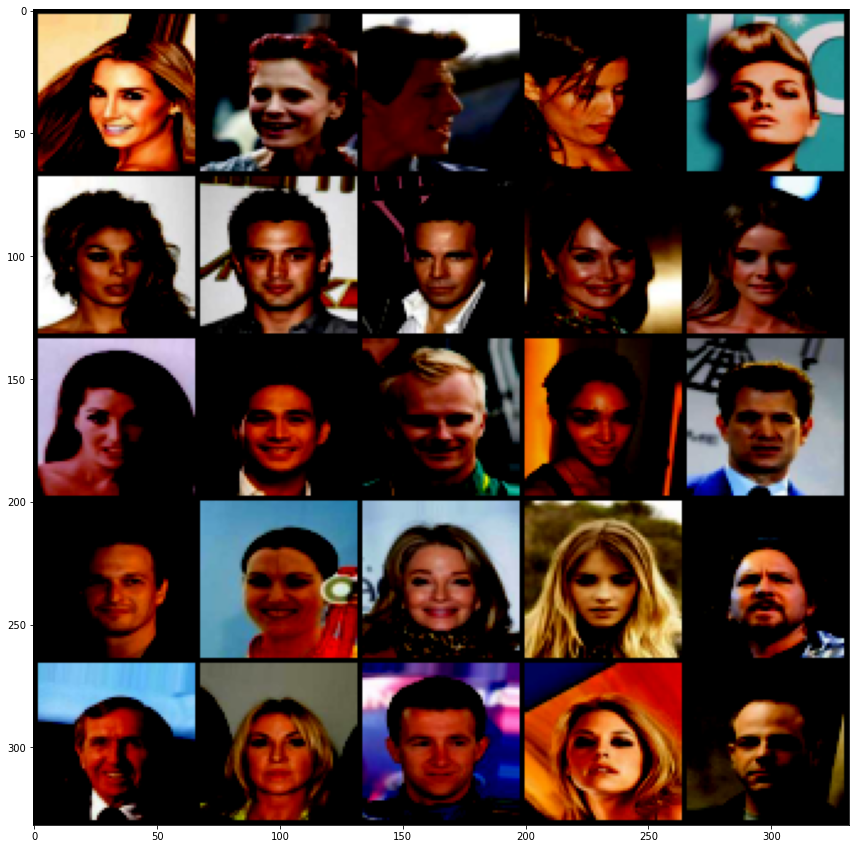

In [6]:
from torchvision.utils import make_grid
plt.figure(figsize=(15,15))
plt.imshow(make_grid([full_dataset[i][0] for i in range(25)], nrow=5).permute(1,2,0))

# WGAN

<center>

Earth Mover Distance (EMD, Wasserstein) distance illustration

![](https://qph.fs.quoracdn.net/main-qimg-b579b7e100750529c32e9f209f53f8a1.webp)

![](https://miro.medium.com/max/800/1*NPxy6I_x1FuGHfIXN4TVyw.png)


<!-- ![](https://miro.medium.com/max/403/1*B47z2jEUNI65-ArwEVnFHw.png) -->

Formula

![](https://slideplayer.com/slide/9533415/30/images/21/%28Wasserstein+distance%29.jpg)

**It is intractable!**

Equivalent form of wassertein distance (Kantorovich-rubinstein duality)

![](https://miro.medium.com/max/3028/1*6y-tz57odJpHh4pwRfXACw.png)

</center>

In [7]:
# https://github.com/CharlesNord/WGAN-GP-DRAGAN-Celeba-Pytorch/blob/master/models_64x64.py


import torch
import torch.nn as nn


class Generator(nn.Module):

    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()

        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())

        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU())
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh())

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y


class Discriminator(nn.Module):

    def __init__(self, in_dim, dim=64):
        super().__init__()

        def conv_ln_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.InstanceNorm2d(out_dim, affine=True),
                nn.LeakyReLU(0.2))

        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), nn.LeakyReLU(0.2),
            conv_ln_lrelu(dim, dim * 2),
            conv_ln_lrelu(dim * 2, dim * 4),
            conv_ln_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4))

    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

In [8]:
z_dim = 100
img_dim = 3

D = Discriminator(img_dim).to(device)
G = Generator(z_dim).to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [9]:
batches_done = 0
n_epochs = 50
n_critic = 5

with tqdm(total=n_epochs*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:
  for epoch in range(n_epochs):
      for i, (imgs, _) in enumerate(dataloader):
          # Configure input
          real_imgs = imgs.to(device)

          # ---------------------
          #  Train Discriminator
          # ---------------------

          d_optimizer.zero_grad()

          # Sample noise as generator input

          z = torch.randn(imgs.shape[0],z_dim,device=device)
          
          # Generate a batch of images
          fake_imgs = G(z)

          # Real images
          real_validity = D(real_imgs)
          # Fake images
          fake_validity = D(fake_imgs)
          # Adversarial loss
          d_loss = -torch.mean(real_validity) + torch.mean(fake_validity)

          d_loss.backward()
          d_optimizer.step()

          # Train the generator every n_critic steps
          if i % n_critic == 0:
              g_optimizer.zero_grad()

              # -----------------
              #  Train Generator
              # -----------------

              # Generate a batch of images
              fake_imgs = G(z)
              # Loss measures generator's ability to fool the discriminator
              # Train on fake images
              fake_validity = D(fake_imgs)
              g_loss = -torch.mean(fake_validity)

              g_loss.backward()
              g_optimizer.step()
          
          pbar.set_description(f"[D loss: {d_loss.item():.2f}] [G loss: {g_loss.item():.2f}]")
          pbar.update(1)

          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


[D loss: ?] [G loss: ?]:   0%|          | 0/158250 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(17,40))
plt.imshow(make_grid(fake_imgs, nrow=4).detach().cpu().permute(1,2,0))

# WGAN-GP

<center>

![](https://miro.medium.com/max/3028/1*6y-tz57odJpHh4pwRfXACw.png)

</center>

Идея: давайте обеспечим 1-липшицевость регуляризацией по производным

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(real_samples.shape[0], requires_grad=False, device=device), # gradients w.t. output. 1 is default
        create_graph=True,
        retain_graph=True, # keep all gradients for further optimization steps
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
z_dim = 100
img_dim = 3

D = Discriminator(img_dim).to(device)
G = Generator(z_dim).to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
lambda_gp = 10
batches_done = 0
n_epochs = 50
n_critic = 5

with tqdm(total=n_epochs*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:

  for epoch in range(n_epochs):
      for i, (imgs, _) in enumerate(dataloader):

          # Configure input
          real_imgs = imgs.to(device)

          # ---------------------
          #  Train Discriminator
          # ---------------------

          d_optimizer.zero_grad()

          # Sample noise as generator input

          z = torch.randn(imgs.shape[0],z_dim,device=device)
          
          # Generate a batch of images
          fake_imgs = G(z)

          # Real images
          real_validity = D(real_imgs)
          # Fake images
          fake_validity = D(fake_imgs)
          # Gradient penalty
          gradient_penalty = compute_gradient_penalty(D, real_imgs.data, fake_imgs.data)
          # Adversarial loss
          d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

          d_loss.backward()
          d_optimizer.step()


          # Train the generator every n_critic steps
          if i % n_critic == 0:
              g_optimizer.zero_grad()

              # -----------------
              #  Train Generator
              # -----------------

              # Generate a batch of images
              fake_imgs = G(z)
              # Loss measures generator's ability to fool the discriminator
              # Train on fake images
              fake_validity = D(fake_imgs)
              g_loss = -torch.mean(fake_validity)

              g_loss.backward()
              g_optimizer.step()

          
          pbar.set_description(f"[D loss: {d_loss.item():.2f}] [G loss: {g_loss.item():.2f}]")
          pbar.update(1)


In [ ]:
plt.figure(figsize=(17,40))
plt.imshow(make_grid(fake_imgs, nrow=4).detach().cpu().permute(1,2,0))

# Spectral normalization

By definition, Lipschitz norm $||g||_{Lip}$ is equal to $sup_h \sigma(∇g(h))$, where $\sigma(A)$ is the spectral norm of the matrix A (L2 matrix norm of A):

$$
\sigma(A)=max_{h\neq0}\frac{||Ah||_2}{||h||_2}=max_{||h||_2\leq1}||Ah||_2
$$

Thus, for any L-Lipschitz $g(\cdot)$ we can obtain 1-Lipschitz $\tilde{g}(\cdot)=\frac{g(\cdot)}{\sigma(g)}$ 

In [ ]:
from torch.nn.utils import spectral_norm as SpectralNorm


class DiscriminatorSN(nn.Module):

    def __init__(self, in_dim, dim=64):
        super().__init__()

        def conv_ln_lrelu(in_dim, out_dim):
            return nn.Sequential(
                SpectralNorm(nn.Conv2d(in_dim, out_dim, 5, 2, 2)),
                nn.InstanceNorm2d(out_dim, affine=True),
                nn.LeakyReLU(0.2))

        self.ls = nn.Sequential(
            SpectralNorm(nn.Conv2d(in_dim, dim, 5, 2, 2)), nn.LeakyReLU(0.2),
            conv_ln_lrelu(dim, dim * 2),
            conv_ln_lrelu(dim * 2, dim * 4),
            conv_ln_lrelu(dim * 4, dim * 8),
            SpectralNorm(nn.Conv2d(dim * 8, 1, 4)))

    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

In [ ]:
z_dim = 100
img_dim = 3

D = DiscriminatorSN(img_dim).to(device)
G = Generator(z_dim).to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
batches_done = 0
n_epochs = 50
n_critic = 5

with tqdm(total=n_epochs*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:

  for epoch in range(n_epochs):
      for i, (imgs, _) in enumerate(dataloader):

          # Configure input
          real_imgs = imgs.to(device)

          # ---------------------
          #  Train Discriminator
          # ---------------------

          d_optimizer.zero_grad()

          # Sample noise as generator input

          z = torch.randn(imgs.shape[0],z_dim,device=device)
          
          # Generate a batch of images
          fake_imgs = G(z)

          # Real images
          real_validity = D(real_imgs)
          # Fake images
          fake_validity = D(fake_imgs)
          # Adversarial loss
          d_loss = -torch.mean(real_validity) + torch.mean(fake_validity)

          d_loss.backward()
          d_optimizer.step()


          # Train the generator every n_critic steps
          if i % n_critic == 0:
              
              g_optimizer.zero_grad()
              # -----------------
              #  Train Generator
              # -----------------

              # Generate a batch of images
              fake_imgs = G(z)
              # Loss measures generator's ability to fool the discriminator
              # Train on fake images
              fake_validity = D(fake_imgs)
              g_loss = -torch.mean(fake_validity)

              g_loss.backward()
              g_optimizer.step()

          
          pbar.set_description(f"[D loss: {d_loss.item():.2f}] [G loss: {g_loss.item():.2f}]")
          pbar.update(1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


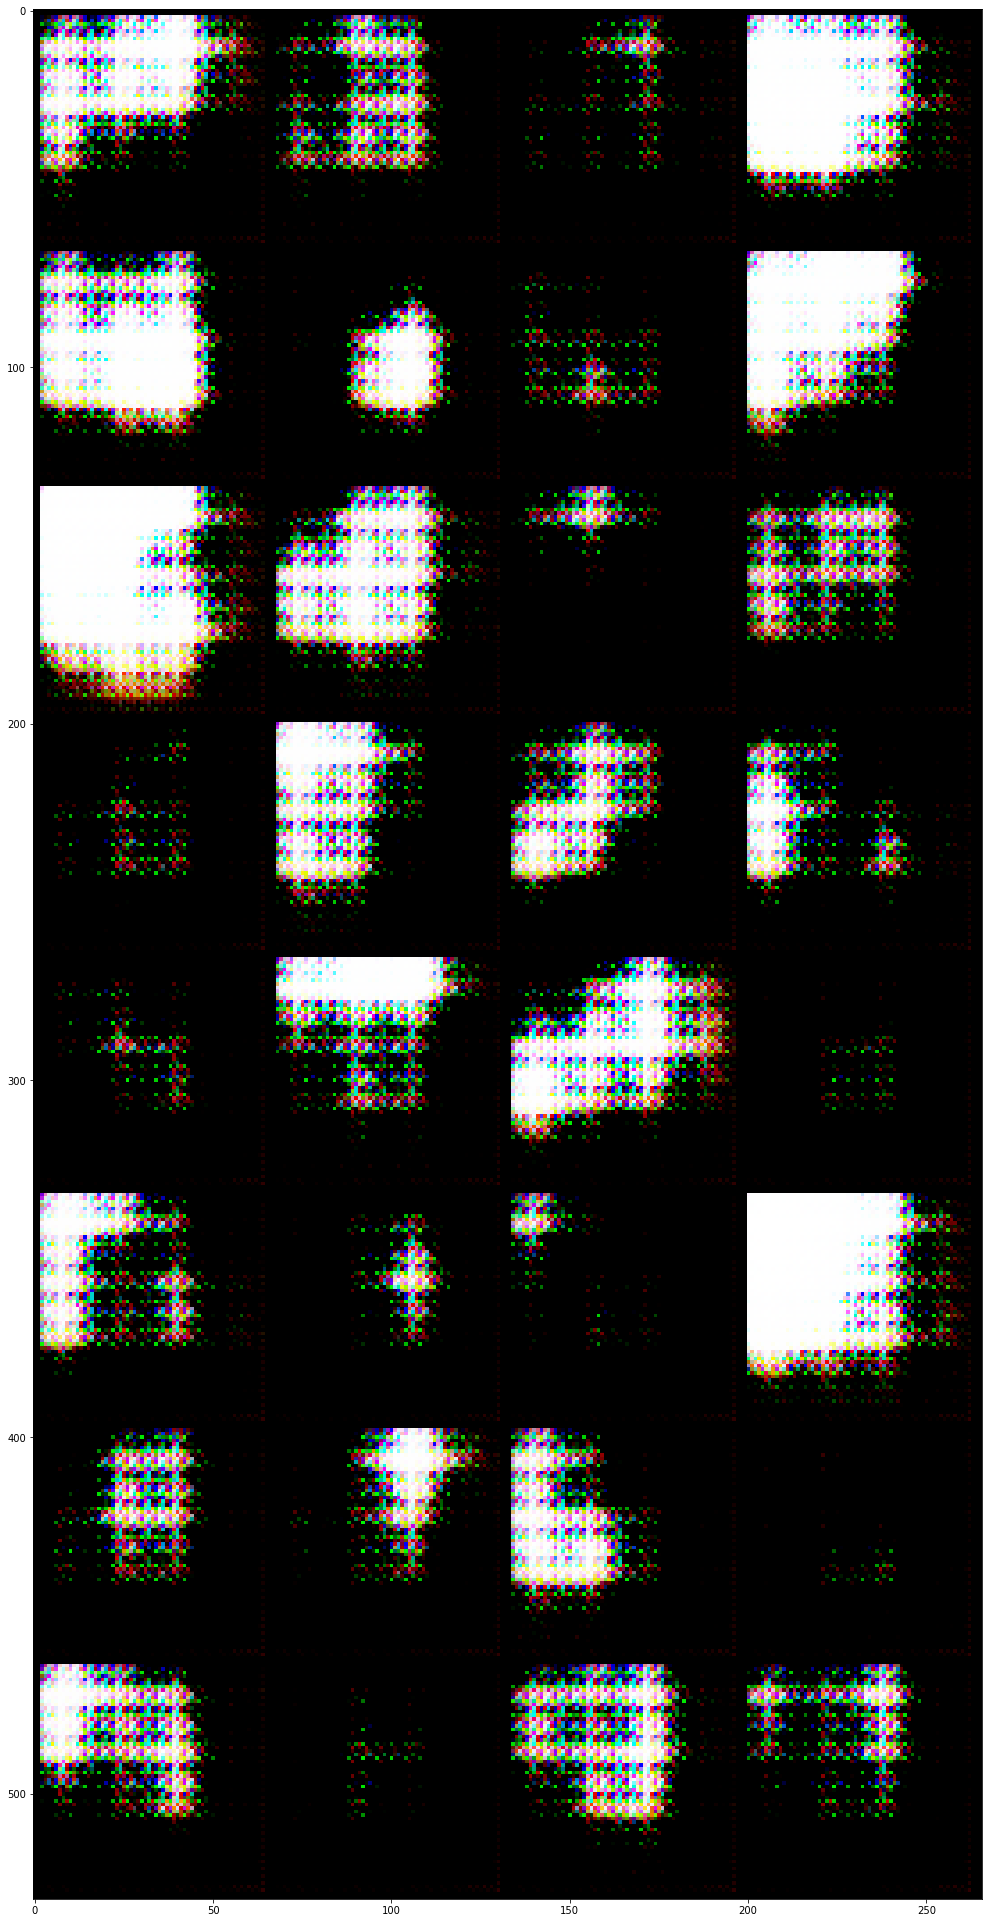

In [ ]:
plt.figure(figsize=(17,40))
plt.imshow(make_grid(fake_imgs, nrow=4).detach().cpu().permute(1,2,0))

# Полезные ссылки

* https://github.com/eriklindernoren/PyTorch-GAN - Имплементации разных ганов
* https://arxiv.org/abs/1704.00028 - WGAN(-GP)
* https://arxiv.org/abs/1802.05957 - Spectral Normalization
* https://becominghuman.ai/all-about-normalization-6ea79e70894b - разные виды нормализаций и чем они друг от друга отличаются
* https://github.com/Lornatang/CycleGAN-PyTorch - CycleGAN (StyleTransfer)
* https://distill.pub/2016/deconv-checkerboard/ - про правильный апсемплинг